In [276]:
import json
import numpy as np
from PIL import Image
from keras_preprocessing import image
import numpy as np
import pandas as pd
from keras import applications
import numpy as np
import imutils
from tqdm import tqdm
from keras.layers import Dropout, Dense, Activation, GlobalAveragePooling2D

In [277]:

start = time.time()
final_result = {}
for imagePath in tqdm(glob.glob(r"/Users/subir/Codes/Miscellaneous/MAD/TASK1/sample_testset/images" + "/*.jpg")):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    crop_match_list = []
    for templatePath in glob.glob("/Users/subir/Codes/Miscellaneous/MAD/TASK1/sample_testset/crops" + "/*.jpg"):
        template = cv2.imread(templatePath, 0)
        (tH, tW) = template.shape[:2]
        found = None
        for scale in np.linspace(0.2, 1.0, 20)[::-1]:
            resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
            r = gray.shape[1] / float(resized.shape[1])
            if resized.shape[0] < tH or resized.shape[1] < tW:
                break
            result = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
            (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
            position = np.where(result >= 0.95)
            for point in zip(*position[::-1]):
                found = (point, r)
        if found:
            (maxLoc, r) = found
            (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
            (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
            crop_match_list.append([os.path.basename(templatePath).replace('.jpg', ''), [startX, startY, endX, endY]])

    final_result[os.path.basename(imagePath).replace('.jpg', '')]=[]
    final_result[os.path.basename(imagePath).replace('.jpg', '')] = crop_match_list


end = time.time()
print("--- %s seconds Execution Time---" % (end - start))


100%|██████████| 62/62 [06:06<00:00,  5.91s/it]

--- 366.4217929840088 seconds Execution Time---


In [5]:
def get_images(file_list):
        target_size = (299, 299)
        images = []
        for file in file_list:
            img = Image.open(file)
            if img.size != target_size:
                img = img.resize(target_size)
            img = image.img_to_array(img)
            img /= 255.
            images.append(img)
        return np.array(images)

In [7]:
base_model = applications.InceptionV3(weights="imagenet", include_top=False,
                                          input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)

In [13]:
from keras.models import Model
model = Model(inputs=base_model.input, outputs=x)

In [8]:
import os,glob

In [109]:
image_names = glob.glob('sample_testset/images/*')
crops_names = glob.glob('sample_testset/crops/*')

In [126]:
image_names= [image_names[i].split('/')[-1].replace('.jpg','') for i in range(len(image_names))]

In [127]:
crops_names= [crops_names[i].split('/')[-1].replace('.jpg','') for i in range(len(crops_names))]

In [63]:
images=get_images(glob.glob(os.path.join('sample_testset/images','*.jpg')))

In [64]:
crops=get_images(glob.glob(os.path.join('sample_testset/crops','*.jpg')))

In [65]:
images_features=model.predict(images)

In [66]:
crops_features=model.predict(crops)

In [67]:
from sklearn.decomposition import PCA

In [68]:
pca = PCA(2)

In [69]:
pca_imgs=pca.fit_transform(images_features)
pca_crops=pca.fit_transform(crops_features)

In [215]:
filename = 'finalized_pca_model.sav'
pickle.dump(pca, open(filename, 'wb'))

In [128]:
principalDf_img = pd.DataFrame(
    {'principal component 1':pca_imgs[:,0],'principal component 2':pca_imgs[:,1],'Images':image_names})

In [129]:
principalDf_crops = pd.DataFrame(
    {'principal component 1':pca_crops[:,0],'principal component 2':pca_crops[:,1],'Images':crops_names})

In [113]:
import matplotlib.pyplot as plt

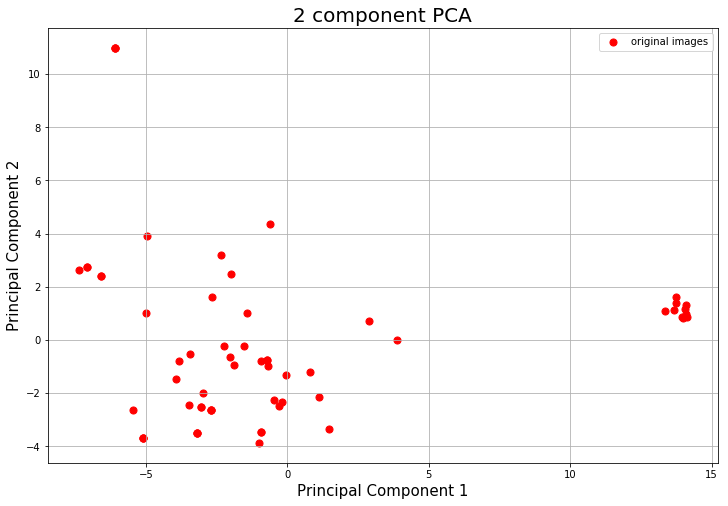

In [140]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['original images']
colors = ['b']
ax.scatter(principalDf_img['principal component 1']
           , principalDf_img['principal component 2']
           , c = color
           , s = 50)
ax.legend(targets)
ax.grid()

In [156]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

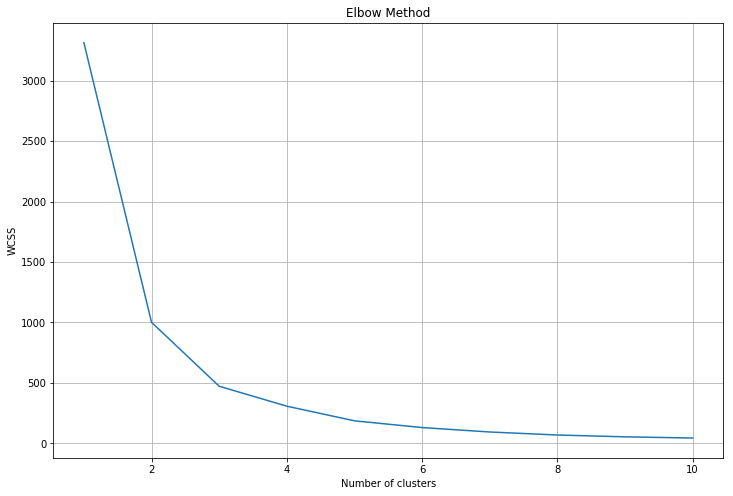

In [178]:
fig = plt.figure(figsize = (12,8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(principalDf_img.drop('Images',1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

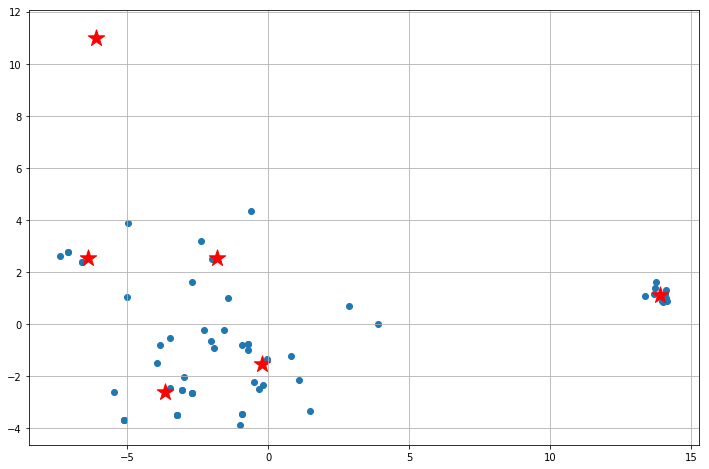

In [183]:
fig = plt.figure(figsize = (12,8))
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans_imgs = kmeans.fit(pca_imgs)
pred_y = kmeans_imgs.predict(pca_imgs)
plt.scatter(pca_imgs[:,0], pca_imgs[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red',marker='*')
plt.grid()
plt.show()

In [210]:
# save the model to disk
import pickle
filename = 'finalized_kmeans_model.sav'
pickle.dump(kmeans_imgs, open(filename, 'wb'))

In [211]:
loaded_model = pickle.load(open(filename, 'rb'))

In [137]:
y_min,y_max=(min(principalDf_img['principal component 2']),max(principalDf_img['principal component 2']))

x_min,x_max=(min(principalDf_img['principal component 1']),max(principalDf_img['principal component 1']))

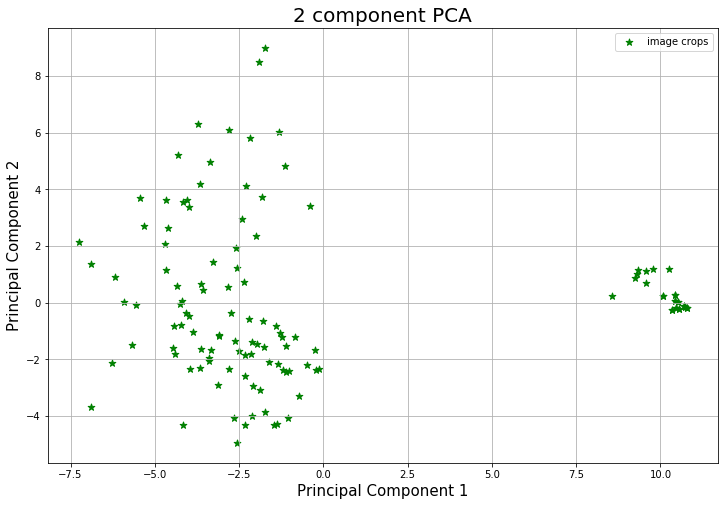

In [180]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['image crops']
ax.scatter(principalDf_crops['principal component 1']
           , principalDf_crops['principal component 2']
           , c = 'g'
           , s = 50 , marker='*')
ax.legend(targets)
ax.grid()

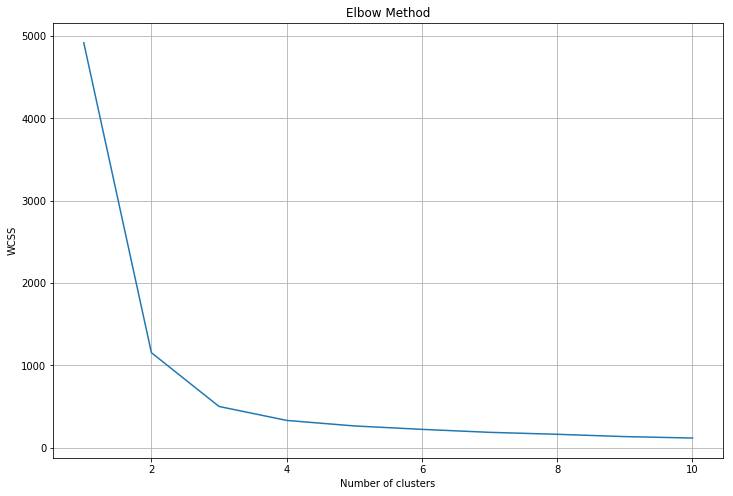

In [181]:
fig = plt.figure(figsize = (12,8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(principalDf_crops.drop('Images',1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

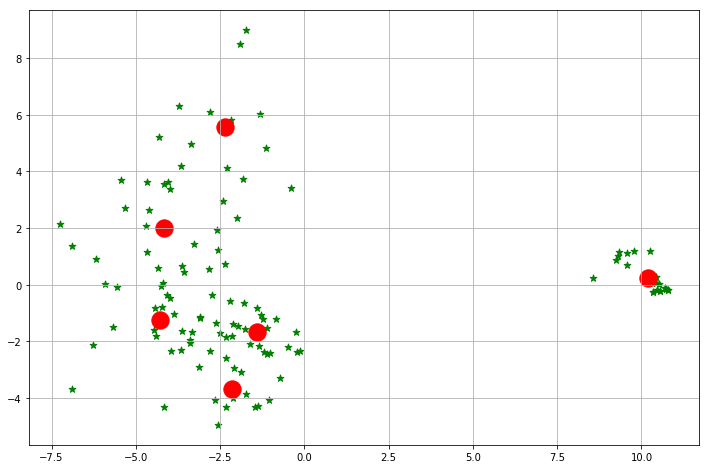

In [184]:
fig = plt.figure(figsize = (12,8))
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans_crops = kmeans.fit(pca_crops)
pred_y = kmeans_crops.predict(pca_crops)
plt.scatter(pca_crops[:,0], pca_crops[:,1], c = 'g', s = 50 , marker='*')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.grid()
plt.show()

In [260]:
with open('./sample_testset/out_res.json') as f:
    content = json.load(f)

In [261]:
content

{'00c58d88-53e0-5314-947d-4763004df6df': [['625dd192-96cc-59cd-83d0-ad5fa710b4bb',
   [250, 243, 379, 327]],
  ['0dbcd814-e138-560d-b30a-752355fc2d9f', [80, 265, 203, 545]],
  ['e89536f7-8c02-5c66-9164-56b630ffd3eb', [111, 102, 282, 447]],
  ['9bbdd7e2-d9e4-558f-b180-235c47099c7e', [88, 532, 161, 600]]],
 'c82b21ed-f9e2-5e32-9567-0882e25e4f76': [['76a0179c-e4b4-5623-8643-be37a418e627',
   [121, 237, 275, 563]],
  ['940f83be-0b9a-5e1e-ab8b-e17180e3e5fa', [88, 120, 290, 308]],
  ['a8c28b66-32d8-571a-ad5f-26c3bf1cd112', [172, 132, 269, 241]]],
 'f2d04823-e49f-56f6-84fa-850e62b53ab8': [['407bc86a-2f9e-57c0-892f-ffdb42b667a5',
   [141, 97, 266, 290]],
  ['137a5083-c54a-5975-ba3c-9830fc97cb84', [106, 299, 162, 373]],
  ['848353df-dba9-5c2c-8bed-7748959f965f', [146, 142, 271, 433]]],
 '846df95d-407f-47d3-8518-52b7adadef14': [['f00ad669-0057-4d82-b487-98a8ca604abe',
   'r'],
  ['f2159555-664a-411c-aab1-df9e46fa2578', 'r']],
 'd2203689-55c8-5bcb-91e7-e3e8a0f8d940': [['3a1bd28f-0a5e-539c-9110-25

In [147]:
image_id='00c58d88-53e0-5314-947d-4763004df6df'
crops_ids = [x[0] for x in content['00c58d88-53e0-5314-947d-4763004df6df']]

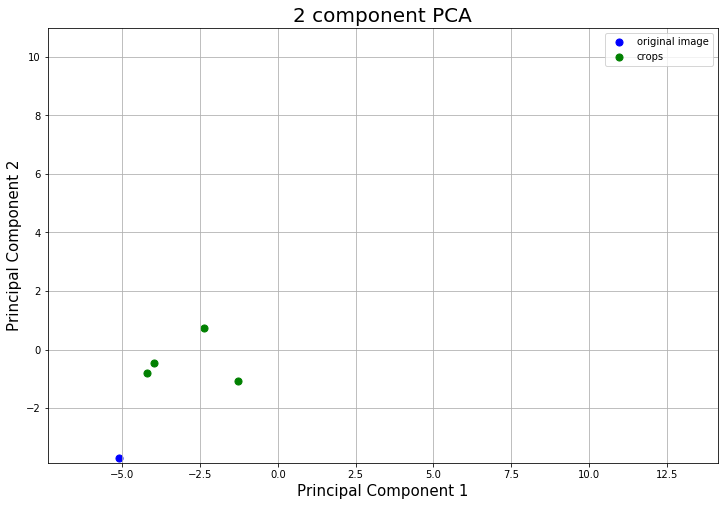

In [148]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['original image','crops']
ax.scatter(principalDf_img[principalDf_img.Images==image_id]['principal component 1']
           , principalDf_img[principalDf_img.Images==image_id]['principal component 2']
           , c = 'b'
           , s = 50)

for crop_id in crops_ids:
    ax.scatter(principalDf_crops[principalDf_crops.Images==crop_id]['principal component 1']
               , principalDf_crops[principalDf_crops.Images==crop_id]['principal component 2']
               , c = 'g'
               , s = 50)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
ax.legend(targets)
ax.grid()

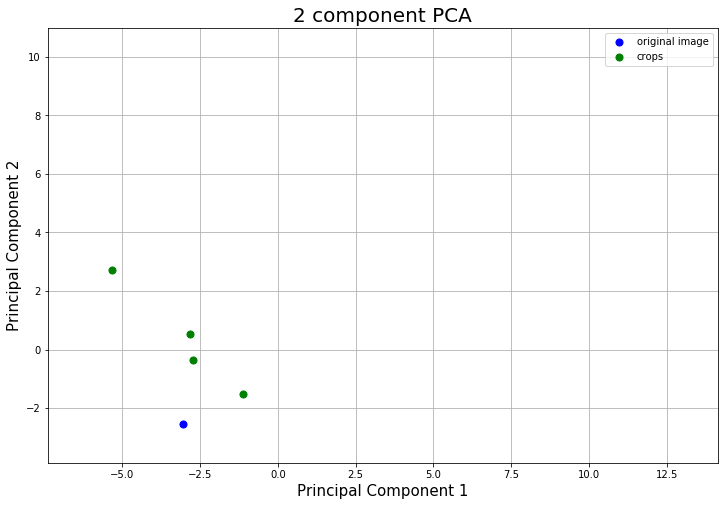

In [146]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)


ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


targets = ['original image','crops']
ax.scatter(principalDf_img[principalDf_img.Images==image_id]['principal component 1']
           , principalDf_img[principalDf_img.Images==image_id]['principal component 2']
           , c = 'b'
           , s = 50)

for crop_id in crops_ids:
    ax.scatter(principalDf_crops[principalDf_crops.Images==crop_id]['principal component 1']
               , principalDf_crops[principalDf_crops.Images==crop_id]['principal component 2']
               , c = 'g'
               , s = 50)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
ax.legend(targets)
ax.grid()

In [270]:

for key,val in content.items():
    image_id = key
    crops_id_list = val
    try:
        x=principalDf_img.loc[principalDf_img.Images==image_id,'principal component 1'].values[0]
        y=principalDf_img.loc[principalDf_img.Images==image_id,'principal component 2'].values[0]
        
        img_cluster = loaded_model.predict(np.asarray([x,y]).reshape(1,-1))
        print('\n')
        print('Image cluster Number:{}'.format(img_cluster))
        print(image_id)
        principalDf_img.loc[principalDf_img.Images==image_id,'cluster_no']=img_cluster
        for crops_id in crops_id_list:
            x_crop=principalDf_crops.loc[principalDf_crops.Images==crops_id[0],'principal component 1'].values[0]
            y_crop=principalDf_crops.loc[principalDf_crops.Images==crops_id[0],'principal component 2'].values[0]
            crop_cluster=loaded_model.predict(np.asarray([x,y]).reshape(1,-1))
            principalDf_crops.loc[principalDf_crops.Images==crops_id[0],'cluster_no']=crop_cluster
            print('Crop cluster Number:{}'.format(crop_cluster))
    except Exception as e:
        print(e)



Image cluster Number:[0]
00c58d88-53e0-5314-947d-4763004df6df
Crop cluster Number:[0]
Crop cluster Number:[0]
Crop cluster Number:[0]
Crop cluster Number:[0]


Image cluster Number:[2]
c82b21ed-f9e2-5e32-9567-0882e25e4f76
Crop cluster Number:[2]
Crop cluster Number:[2]
Crop cluster Number:[2]


Image cluster Number:[0]
f2d04823-e49f-56f6-84fa-850e62b53ab8
Crop cluster Number:[0]
Crop cluster Number:[0]
Crop cluster Number:[0]


Image cluster Number:[1]
846df95d-407f-47d3-8518-52b7adadef14
Crop cluster Number:[1]
Crop cluster Number:[1]


Image cluster Number:[4]
d2203689-55c8-5bcb-91e7-e3e8a0f8d940
Crop cluster Number:[4]
Crop cluster Number:[4]


Image cluster Number:[0]
3ca9dd7e-1b8b-5a2c-8017-05c13682402e
Crop cluster Number:[0]
Crop cluster Number:[0]


Image cluster Number:[4]
64b05eb4-2817-509d-aa5d-82119c15ea36
Crop cluster Number:[4]
Crop cluster Number:[4]


Image cluster Number:[2]
21d62ca5-5a13-55d7-876b-0a9ce1ed47c8
Crop cluster Number:[2]
Crop cluster Number:[2]
Crop clu

In [273]:
# --- 375.92647194862366 seconds Execution Time---

In [239]:
import json
import os, glob
import cv2
import numpy as np
import imutils
import time

In [271]:
final_result={}
start = time.time()
for row in principalDf_img.iterrows():
    crop_match_list=[]
    img_id = row[1]['Images']
    img_cluster = row[1]['cluster_no']
    imagePath = os.path.join('sample_testset/images/',img_id+'.jpg')
    print(imagePath)
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    crop_ids = principalDf_crops[principalDf_crops.cluster_no==img_cluster]['Images'].values
    for crop_id in crop_ids:
        templatePath = os.path.join('sample_testset/crops/',crop_id+'.jpg')
        template = cv2.imread(templatePath, 0)
        (tH, tW) = template.shape[:2]
        found = None
        for scale in np.linspace(0.2, 1.0, 20)[::-1]:
            resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
            r = gray.shape[1] / float(resized.shape[1])
            if resized.shape[0] < tH or resized.shape[1] < tW:
                break
            result = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
            (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
            position = np.where(result >= 0.95)
            for point in zip(*position[::-1]):
                found = (point, r)
        if found:
            (maxLoc, r) = found
            (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
            (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
            crop_match_list.append([os.path.basename(templatePath).replace('.jpg', ''), [startX, startY, endX, endY]])
    
    final_result[os.path.basename(imagePath).replace('.jpg', '')]=[]
    final_result[os.path.basename(imagePath).replace('.jpg', '')] = crop_match_list
            

end = time.time()
print("--- %s seconds Execution Time---" % (end - start))

sample_testset/images/d469bcc8-d501-5b75-81b0-00eabb7a2238.jpg
sample_testset/images/f2d04823-e49f-56f6-84fa-850e62b53ab8.jpg
sample_testset/images/40890023-03f3-5226-af83-0cfe775187b8.jpg
sample_testset/images/e6bc80be-bab6-5772-8a84-177c33245a3a.jpg
sample_testset/images/a11b221c-d443-4dd7-9068-cf4914375751.jpg
sample_testset/images/c1c1d077-8331-5811-9614-d83012afd37f.jpg
sample_testset/images/13e86ee2-f02a-5246-8554-f9ae7ba22ca9.jpg
sample_testset/images/6fc1d9f2-7647-4f0d-9e34-17e34bef7d62.jpg
sample_testset/images/a0eda751-d15f-4d07-aab4-73126a1391b0.jpg
sample_testset/images/7a0dc2f2-75f2-4ad3-a2aa-ca9f1681c329.jpg
sample_testset/images/e562cdea-ece0-5d64-8dd8-c7c1ee72ed9b.jpg
sample_testset/images/d70fafda-0d9d-4c64-acc4-d40fa5dacd87.jpg
sample_testset/images/64b05eb4-2817-509d-aa5d-82119c15ea36.jpg
sample_testset/images/4e1a07f3-b483-472d-bf26-851772e91ed0.jpg
sample_testset/images/25f71cd6-cfae-4975-a757-9c1be7cac4d3.jpg
sample_testset/images/b3365b00-ae61-5420-b93c-a02f0abde